### Accurate Uncertainties for Deep Learning Using Calibrated Regression
**Anthony Rentsch and Abhimanyu Vasishth**

An implementation and overview of the [2018 paper](https://arxiv.org/abs/1807.00263) by Kuleshov et al.

---

In [1]:
# packages
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn import svm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### Problem Statement 

what is the problem the paper aims to solve?

#### Background 

why is this problem important or interesting?

#### Existing work 

what has been done in literature?

#### Contribution 

what is gap in literature that the paper is trying to fill? What is the unique contribution

#### Technical content 

high level - what are the high level ideas behind their technical contribution
details - highlight (not copy and paste entire sections) the relevant details that are important to focus on (e.g. if there's a model, define it; if there is a theorem, state it and explain why it's important, etc).

#### Experiments 

which types of experiments were performed? What claims were these experiments trying to prove? Did the results prove the claims?

#### Evaluation 

(your opinion) - do you think the work is technically sound? Do you think the proposed model/inference method is practical to use on real data and tasks? Do you think the experimental section was strong (there are sufficient evidence to support the claims and eliminate confounding factors)?

#### Future work 

(for those interested in continuing research in a related field) - do you think you can suggest a concrete change or modification that would improve the existing solution(s) to the problem of interest? Try to implement some of these changes/modifications.

#### Code

- At least one clear working pedagogical example demonstrating the problem the paper is claiming to solve. 
- At lease a bare bones implementation of the model/algorithm/solution (in some cases, you may be able to make assumptions  to simplify the model/algorithm/solution with the approval of your instructor)
- Demonstration on at least one instance that your implementation solves the problem.
- Demonstration on at least one instance the failure mode of the model/algorithm/solution, with an explanation for why failure occurred (is the dataset too large? Did you choose a bad hyper parameter?). The point of this is to point out edge cases to the user.

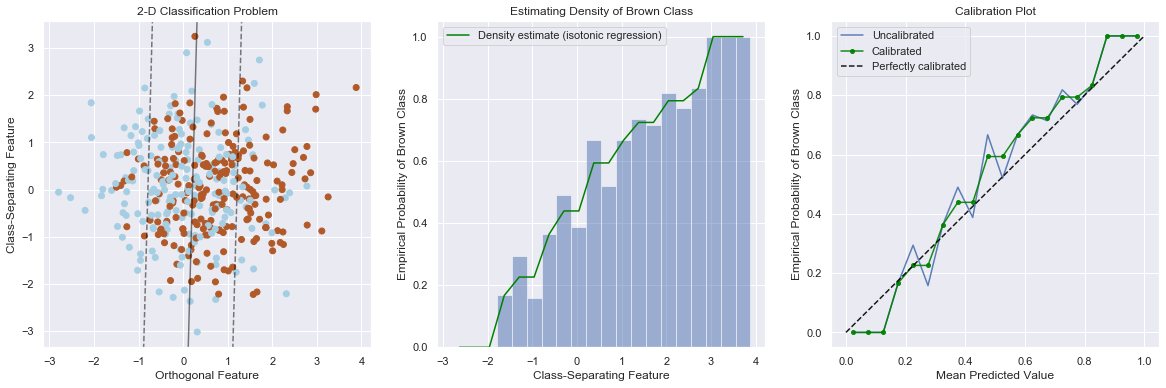

In [2]:
seed = 207
np.random.seed(seed)

npoints=500
X = np.random.normal(size=(npoints,2))
y = np.concatenate((np.ones(shape=(int(npoints/2),)), np.zeros(shape=(int(npoints/2),))), axis=0)
X[:,0] += 0.8*y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, train_size=0.8)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

# Fig 2 Subplotx 1
ax[0].scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.Paired)
ax[0].set_xlabel('Orthogonal Feature')
ax[0].set_ylabel('Class-Separating Feature')
ax[0].set_title('2-D Classification Problem')

# Plotting hyperplane from SVM
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X_train, y_train)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - (clf.intercept_[0]) / w[1]
ax[0].plot(xx,yy, '-', color='black', alpha=0.5)
ax[0].plot(xx+1,yy, '--', color='black', alpha=0.5)
ax[0].plot(xx-1,yy, '--', color='black', alpha=0.5)
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)

# Fig 2 Subplot 2
X_train_proj = X_train[:,0]

# finding the bins
nbins=20
counts, bins = np.histogram(X_train_proj, bins=nbins)

# finding the ratio of class 1 points in each bin
counts_0, bins_0 = np.histogram(X_train_proj[y_train == 0], bins=bins)
counts_1, bins_1 = np.histogram(X_train_proj[y_train == 1], bins=bins)
ratios = counts_1/(counts_0 + counts_1)

# plotting histograms
bin_means = [0.5*(bins[i] + bins[i+1]) for i in range(nbins)]
bin_width = bins[1]-bins[0]

ax[1].bar(bin_means, ratios, alpha=0.5, width=bin_width)
ax[1].set_xlabel('Class-Separating Feature')
ax[1].set_ylabel('Empirical Probability of Brown Class')
ax[1].set_title('Estimating Density of Brown Class')

# isotonic regression
ir = IsotonicRegression()
density_estimate = ir.fit_transform(bin_means, ratios)
ax[1].plot(bin_means, density_estimate, '-', color='green', label='Density estimate (isotonic regression)')
ax[1].legend();

# Fig 2 Subplot 3
xrange = np.linspace(0+0.5/nbins,1-0.5/nbins,nbins)
ax[2].plot(xrange, ratios, alpha=0.9, label='Uncalibrated')
ax[2].plot(xrange, density_estimate, 'o-', color='green', alpha=0.9, label='Calibrated', markersize=4)
ax[2].plot(np.linspace(0,1), np.linspace(0,1), '--' ,color='black', alpha=0.9, label='Perfectly calibrated')
ax[2].set_xlabel('Mean Predicted Value')
ax[2].set_ylabel('Empirical Probability of Brown Class')
ax[2].set_title('Calibration Plot')
ax[2].legend();

**Figure 2** Calibrated classification

*Left*: Two classes are separated by a hyperplane in 2D. The x-axis is especially useful for separating the two classes. 

*Middle*: We project data onto the x-axis and fit a histogram (blue) or an isotonic regression model (green) to estimate the empirical probability of observing the brown class as a function of x. We may use these probabilities as approximately calibrated predictions. 

*Right*: The calibration of the original linear model and its recalibrated version are assessed by binning the predictions into twenty intervals ([0,0.05],(0.05,0.1], ...), and plotting the predicted vs. the observed frequency of the brown class in each interval.

---